# Organization of words into ontology

Last updated: 09142023  
By: Lauren Liao  
Purpose: get word similarity matrix

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from io import StringIO
import io
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import seaborn as sns
import pickle
import scipy
import scipy.cluster.hierarchy as sch

%matplotlib inline

**Constants and functions**

SEED_LST: 10 random seeds of 5 digit primes  
LONG_SEED_LST: 100 random seed of 6 digit  
KEYTERMS: main key terms of interest  
KEYTERM_CAT: categories relevant to the KEYTERMS

_get_similarity_df_ make the similarity matrix into a pandas dataframe  
_get_similarity_across_seeds_ make the similarity dataframe across the seeds

In [13]:
# set random seed lists
SEED_LST = [11113, 12211, 13999, 18947, 49999, 54787, 65537, 69427, 99989, 99991]
LONG_SEED_LST = [756839, 757577, 757727, 765169, 767857, 769591, 773147, 773251, 
                 773473, 774023, 776887, 777643, 777677, 777743, 778879, 779693, 
                 780721, 780799, 783137, 786431, 786983, 787757, 788999, 789101, 
                 789121, 790879, 791663, 792397, 797161, 797581, 800801, 803989, 
                 805723, 806041, 809461, 823541, 823547, 823553, 823679, 823799, 
                 824609, 826669, 826699, 832411, 833719, 835399, 841069, 844427, 
                 853211, 859433, 864203, 864307, 864449, 875491, 880667, 880949, 
                 887113, 894689, 895553, 896723, 900001, 904117, 908909, 909091, 
                 909287, 913579, 914491, 919799, 920209, 923471, 938351, 944689, 
                 945457, 946489, 946801, 946949, 949391, 953593, 953983, 955223, 
                 956401, 960889, 961273, 961397, 962963, 965401, 966727, 968041, 
                 969407, 971389, 971767, 974123, 974159, 974213, 974849, 975313, 
                 975379, 977923, 978403, 980641]

# set keyterms
KEYTERMS = ['health', 'doctor', 'resource', 'class', 
            'race', 'black', 'white', 'bame', 'minority', 
            'racism', 'disadvantaged',
            'discrimination', 'wealth', 'poverty', 'power', 'bias', 'structural', 
            'possibly',
            'perhaps', 'probably', 'likely']

# set category for keyterms
KEYTERM_CAT = [cat_term for sublist in [['basic_terms']*4, 
                                        ['race_related']*5, 
                                        ['racism_or_power_related']*8, 
                                        ['close_reading_informed']*4] for cat_term in sublist]


KEYTERMS2 = ['health', 'patient', 'doctor', 'resource', 'class', 
            'care', 'medical',
            'population', 'social', 'community', 'system',
            'race', 'black', 'white', 'bame', 'minority', 
            'racism', 'disadvantaged',
            'discrimination', 'wealth', 'poverty', 'power', 'bias', 'structural', 
            'ethnic_minority', 'african_american', 'human_right', 'risk_factor',
            'structural_racism', 'racial_ethnic', 'social_determinant', 'life_expectancy']

In [3]:
# get similarity matrix
def get_similarity_df(model):
    """
    Take the Word2Vec model
    Return the similarity matrix for each specification
    """
    vec_by_keys = np.vstack([model.wv.get_vector(k) for k in model.wv.index_to_key])
    word_similarity_df = pd.DataFrame(cosine_similarity(vec_by_keys), 
                                       index=model.wv.index_to_key, 
                                       columns=model.wv.index_to_key)
    
    return(word_similarity_df)

In [4]:
def get_similarity_across_seeds(sentences, 
                                window=5, 
                                min_count=5, 
                                vector_size=128, 
                                seed_lst=SEED_LST,
                                save_to_pickle=False
                               ):
    """
    Goes through different Word2Vec model seed specifications
    Store the resulting dataframes inside of a datafame
    """
    
    # creating an empty data frame
    similarity_across_seeds_df = pd.DataFrame({'seed': seed_lst,
                                               'similarity_df': [None] * len(seed_lst)})

    similarity_across_seeds_df['similarity_df'] = [get_similarity_df(Word2Vec(sentences=sentences,
                                                                              window=window, 
                                                                              min_count=min_count,
                                                                              vector_size=vector_size,
                                                                              seed=seed)) for seed in tqdm(seed_lst)]
    sim_vals = np.zeros((similarity_across_seeds_df.shape[0],
                         similarity_across_seeds_df['similarity_df'][0].shape[0], 
                         similarity_across_seeds_df['similarity_df'][0].shape[0]))
    
    for i, df in enumerate(similarity_across_seeds_df['similarity_df']):
        sim_vals[i] = df.to_numpy()
    
    mean_sim_vals = sim_vals.mean(axis=0)
    std_sim_vals = sim_vals.std(axis=0)

    mean_sim_vals_df = pd.DataFrame(mean_sim_vals, 
                                    index=similarity_across_seeds_df['similarity_df'][0].columns.values,
                                    columns=similarity_across_seeds_df['similarity_df'][0].columns.values)
    std_sim_vals_df = pd.DataFrame(std_sim_vals, 
                                    index=similarity_across_seeds_df['similarity_df'][0].columns.values,
                                    columns=similarity_across_seeds_df['similarity_df'][0].columns.values)
    
    if(save_to_pickle):
        mean_sim_vals_df.to_pickle('../data/similarity_df_mean.pkl')
        std_sim_vals_df.to_pickle('../data/similarity_df_std.pkl')

    return(mean_sim_vals_df, std_sim_vals_df)

**Data loading**  
the data starts with the preprocessed text (pickled) file

In [2]:
# read processed text from previous
full_text = pd.read_pickle('../data/full_data_w_processedtext.pkl')
processed_text = full_text['processed_text'] 

# only working with the this particular column moving forward
sentences = [x for x in processed_text]

## take average similarity across 30 random seeds

get the average and standard deviation then save this 

In [ ]:
%%time
mean_similarity_df, std_similarity_df = get_similarity_across_seeds(sentences, seed_lst=LONG_SEED_LST[:30], save_to_pickle=True)

100%|███████████████████████████████████████████| 30/30 [01:38<00:00,  3.27s/it]


### Example usage

In [3]:
mean_similarity_df = pd.read_pickle("../data/similarity_df_mean.pkl")
std_similarity_df = pd.read_pickle("../data/similarity_df_std.pkl")

In [4]:
word_interest = "health"
mean_similarity_df.sort_values(by= word_interest, ascending=False).iloc[:11][word_interest]

health           1.000000
healthcare       0.704967
housing          0.635157
act              0.633798
judiciary        0.632291
affordable       0.614957
widening         0.614238
improving        0.613803
tsar             0.611413
provision        0.608883
participation    0.606027
Name: health, dtype: float64

In [8]:
print(mean_similarity_df.loc["possibly","racially"])
print(std_similarity_df.loc["possibly","racially"])

print(mean_similarity_df.loc["likely","racially"])
print(std_similarity_df.loc["likely","racially"])

0.9054654618104299
0.01736041337590127
0.5242288023233413
0.030425141901264895


                  likely  possibly  probably     maybe  motivated
racially        0.524229  0.905465  0.847555  0.860164   0.933423
racist          0.291153  0.691515  0.625516  0.811148   0.755968
racism          0.119155  0.447579  0.332674  0.448843   0.488132
discrimination  0.304215  0.487112  0.384871  0.431277   0.510889


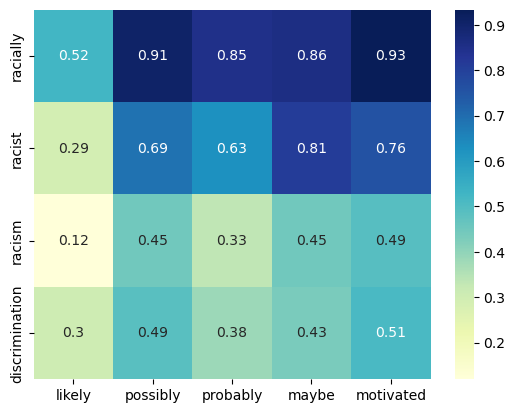

In [9]:
lst_interest = ["likely", "possibly", "probably", "maybe", "motivated"]
print(mean_similarity_df.loc[["racially", "racist", "racism", "discrimination"], lst_interest])
sns.heatmap(mean_similarity_df.loc[["racially", "racist", "racism", "discrimination"], lst_interest], annot=True, cmap="YlGnBu");

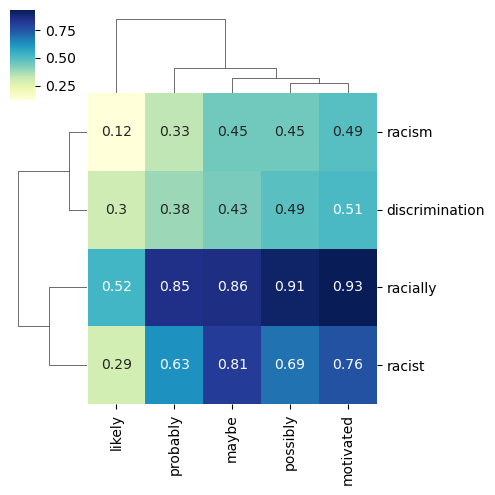

In [10]:
sns.clustermap(mean_similarity_df.loc[["racially", "racist", "racism", "discrimination"], 
                                      lst_interest], annot=True, cmap="YlGnBu", figsize=(5, 5))

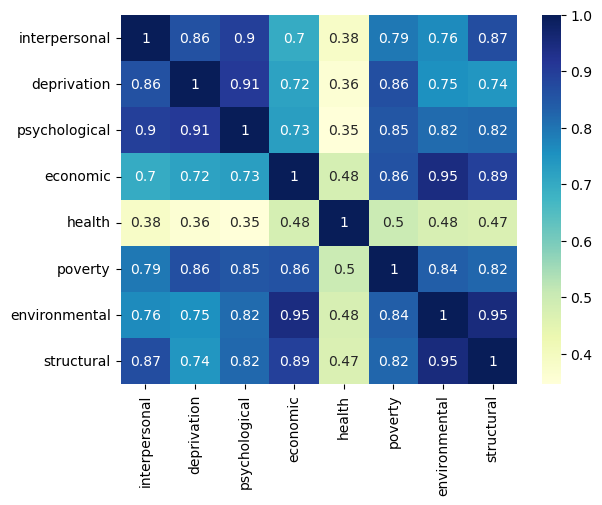

In [26]:
lst_interest = ["interpersonal", "deprivation", "psychological", "economic", 
                "health", "poverty",
                "environmental", "structural"]
# print(mean_similarity_df.loc[lst_interest, lst_interest])
sns.heatmap(mean_similarity_df.loc[lst_interest, lst_interest], annot=True, cmap="YlGnBu");

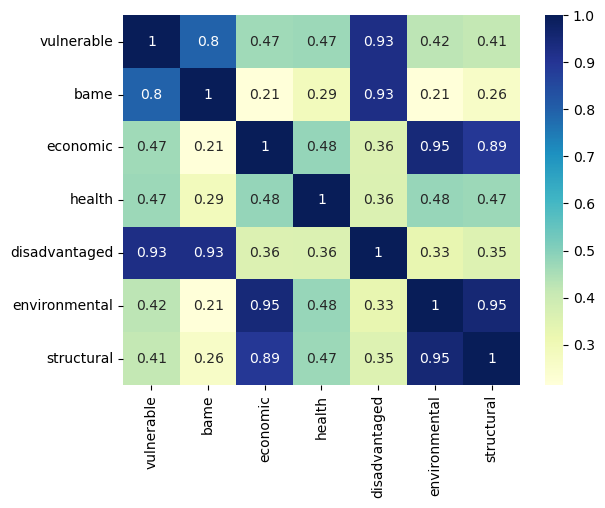

In [29]:
lst_interest = ["vulnerable", "bame", "economic", 
                "health", "disadvantaged",
                "environmental", "structural"]
# print(mean_similarity_df.loc[lst_interest, lst_interest])
sns.heatmap(mean_similarity_df.loc[lst_interest, lst_interest], annot=True, cmap="YlGnBu");

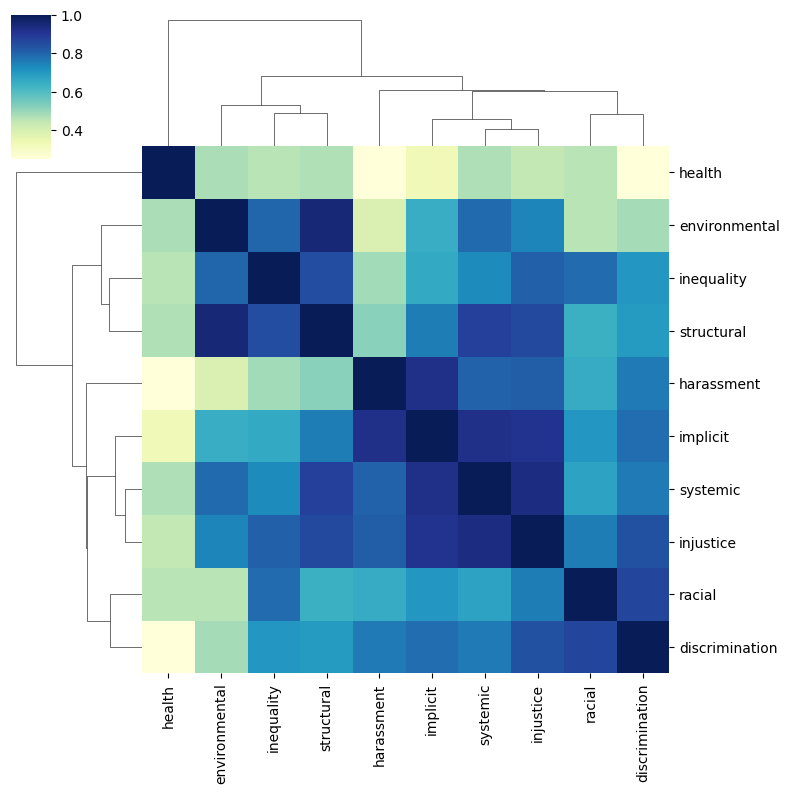

In [38]:
lst_interest = ["racial", "inequality", "systemic", "injustice",
                "harassment", "implicit",
                "health", "discrimination",
                "environmental", "structural"]
# print(mean_similarity_df.loc[lst_interest, lst_interest])
# sns.heatmap(mean_similarity_df.loc[lst_interest, lst_interest], annot=True, cmap="YlGnBu");
sns.clustermap(mean_similarity_df.loc[lst_interest, lst_interest],
               cmap="YlGnBu", figsize=(8, 8));

In [56]:
word_interest = "stereotypical"
mean_similarity_df.sort_values(by= word_interest, ascending=False).iloc[:15][word_interest]

stereotypical    1.000000
entirely         0.985587
outsider         0.985454
passive          0.985365
though           0.984258
discomfort       0.984053
sexist           0.983808
belonging        0.983728
overly           0.982691
acceptance       0.982361
aggression       0.982012
reveal           0.981808
nonverbal        0.981803
supposed         0.981046
label            0.981028
Name: stereotypical, dtype: float64

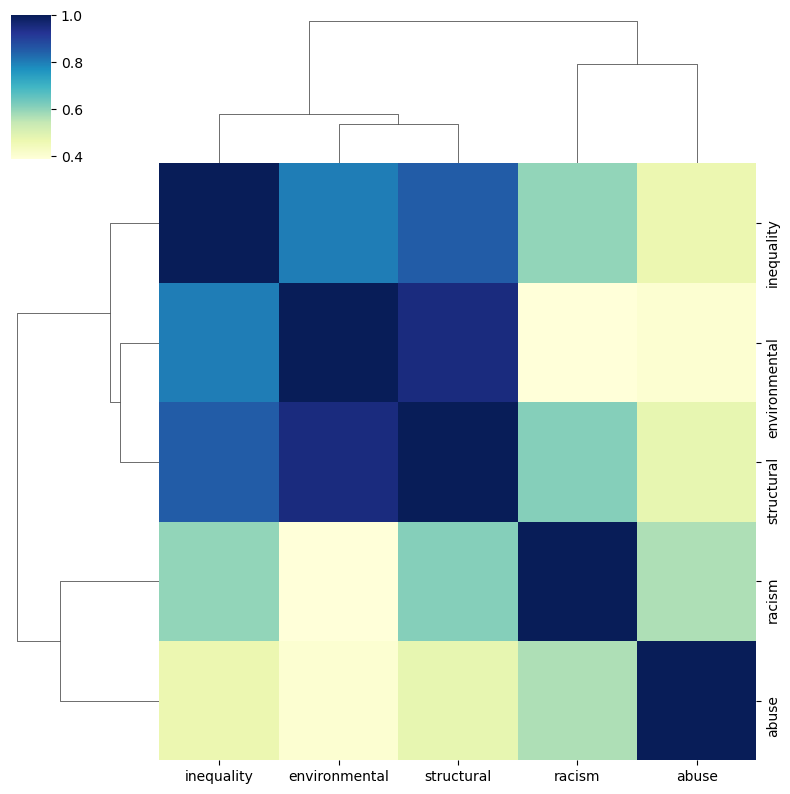

In [39]:
lst_interest = ["racism", "inequality", "abuse",
                "environmental", "structural"]
# print(mean_similarity_df.loc[lst_interest, lst_interest])
# sns.heatmap(mean_similarity_df.loc[lst_interest, lst_interest], annot=True, cmap="YlGnBu");
sns.clustermap(mean_similarity_df.loc[lst_interest, lst_interest],
               cmap="YlGnBu", figsize=(8, 8));

### Preliminary visualizations

In [14]:
results = [({key: value for key, value in 
            zip(mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:11][word_interest].index,
                mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:11][word_interest])})
           for word_interest in tqdm(KEYTERMS2)] #previously tqdm(KEYTERMS)


100%|███████████████████████████████████████████| 32/32 [00:33<00:00,  1.05s/it]


In [5]:
def save_topn_results(n):
    filename = f"../results/top{n}_mean2.pkl"
    with open(filename, 'wb') as file:
        pickle.dump([(word_interest,
            {key: value for key, value in 
            zip(mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:(n+1)][word_interest].index,
                mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:(n+1)][word_interest])})
           for word_interest in tqdm(KEYTERMS2)], file)

In [8]:
def save_topn_results(n):
    filename = f"../results/top{n}_mean_all.pkl"
    with open(filename, 'wb') as file:
        pickle.dump([(word_interest,
            {key: value for key, value in 
            zip(mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:(n+1)][word_interest].index,
                mean_similarity_df.sort_values(by= word_interest, 
                                               ascending=False).iloc[1:(n+1)][word_interest])})
           for word_interest in tqdm(mean_similarity_df.columns)], file)

In [10]:
save_topn_results(30)


100%|█████████████████████████████████████| 9242/9242 [2:16:13<00:00,  1.13it/s]


In [20]:
save_topn_results(30)


100%|███████████████████████████████████████████| 32/32 [00:26<00:00,  1.22it/s]


### Visualization

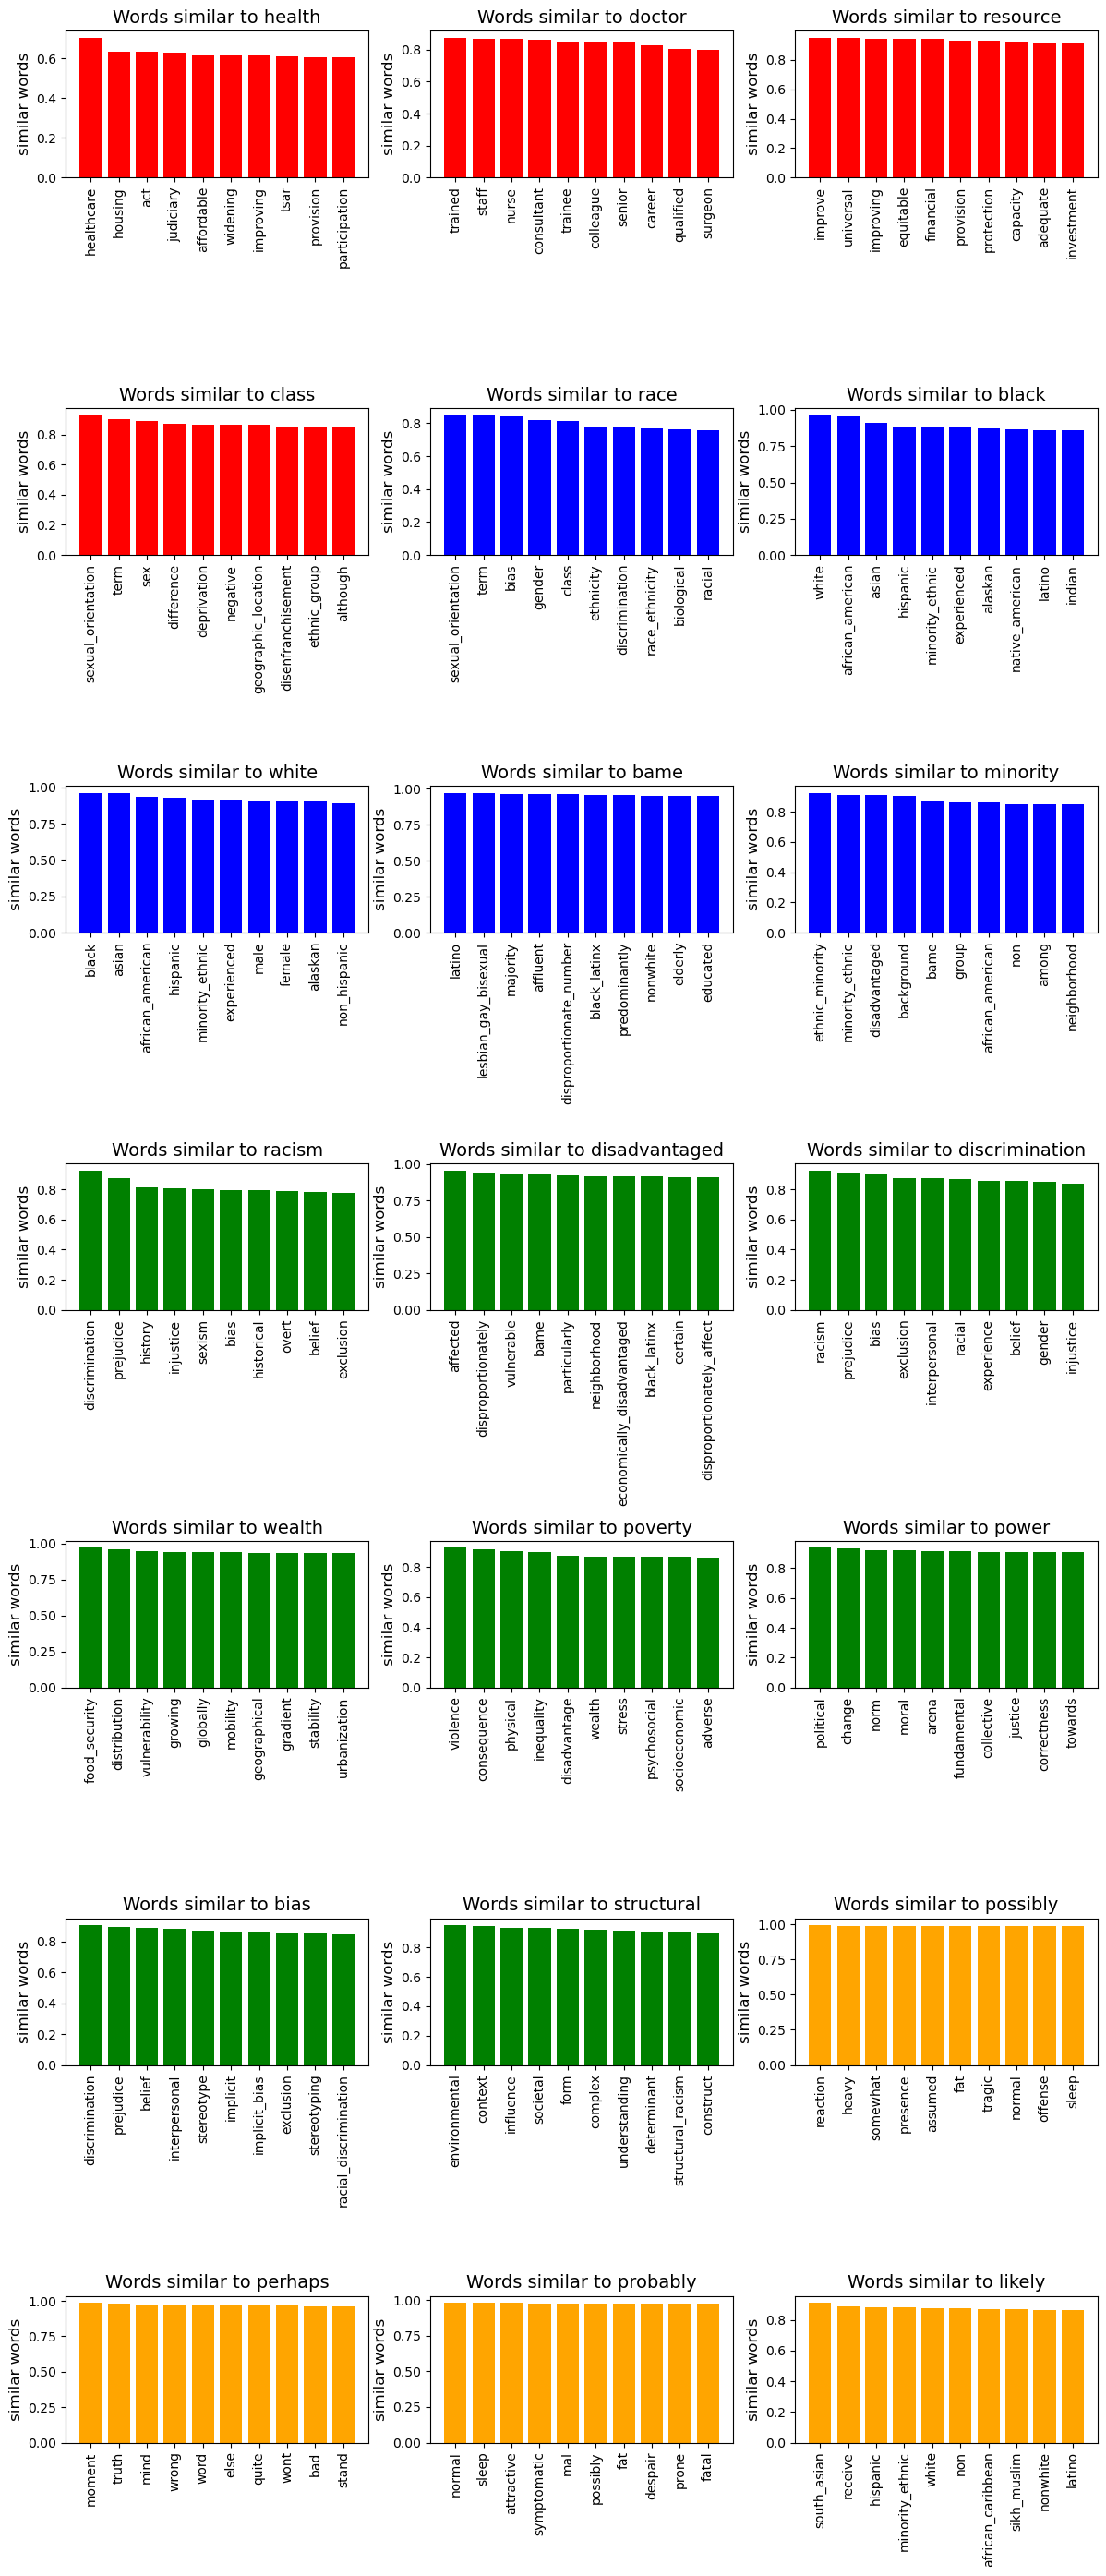

In [27]:
num_plots = len(KEYTERMS)
num_rows = (num_plots - 1) // 3 + 1
num_cols = min(num_plots, 3)
cat_colors = [color for sublist in [['red']*4, 
                                    ['blue']*5, 
                                    ['green']*8, 
                                    ['orange']*4] for color in sublist]
# [(v, k) for k,v in zip(KEYTERMS, KEYTERM_CAT)]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4 * num_rows))
axs = axs.flatten()  # flatten for indexing

for i, keyterm_topvars in enumerate(results):
    kt, topvars_dict = keyterm_topvars
    if(len(topvars_dict) == 0):
        continue;
    topvars_words, topvars_values = zip(*topvars_dict.items())
    
    ax = axs[i]
    ax.bar(topvars_words, topvars_values, label=topvars_words, color=cat_colors[i])

    ax.set_ylabel('similar words', fontsize=12)
    ax.set_title("Words similar to "+kt, fontsize=14)
    ax.tick_params(axis='x', rotation=90)

# Remove any unused subplots
if num_plots < len(axs):
    for j in range(num_plots, len(axs)):
        axs[j].remove()

plt.tight_layout()
plt.savefig('../results/figures/top10_by_mean.png')

In [33]:
keyterm_w_cat = [(v, k) for k,v in zip(KEYTERMS, KEYTERM_CAT)]
top10_words = [(k, main_k.keys()) for k, main_k in results]